In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

In [2]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

In [3]:
data = load_rossi()

In [4]:
data

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [5]:
y = data[["week","arrest"]].rename(
    columns={"week" : "time", "arrest" : "event"}, 
    errors="raise")

In [6]:
X = data[[x for x in data.columns if x not in ["week", "arrest"]]]

In [7]:
X[:5]

,fin,age,race,wexp,mar,paro,prio
0,0,27,1,0,0,1,3
1,0,18,1,0,0,1,8
2,0,19,0,1,0,1,13
3,1,23,1,1,1,1,1
4,0,19,0,1,0,1,3


In [8]:
X1 = X.iloc[:, :3]
X2 = X.iloc[:, 3:]

In [9]:
step1 = pd.concat([y,X1], axis = 1)

In [10]:
step1[:5]

,time,event,fin,age,race
0,20,1,0,27,1
1,17,1,0,18,1
2,25,1,0,19,0
3,52,0,1,23,1
4,52,0,0,19,0


In [11]:
ls = pd.DataFrame(np.zeros(step1.shape[0]), 
                  columns = ['offset'])
step2 = pd.concat([ls,y,X2], axis = 1)

In [12]:
step2[:5]

,offset,time,event,wexp,mar,paro,prio
0,0.0,20,1,0,0,1,3
1,0.0,17,1,0,0,1,8
2,0.0,25,1,1,0,1,13
3,0.0,52,0,1,1,1,1
4,0.0,52,0,1,0,1,3


In [13]:
rossi = load_rossi()

<Axes: xlabel='log(HR) (95% CI)'>

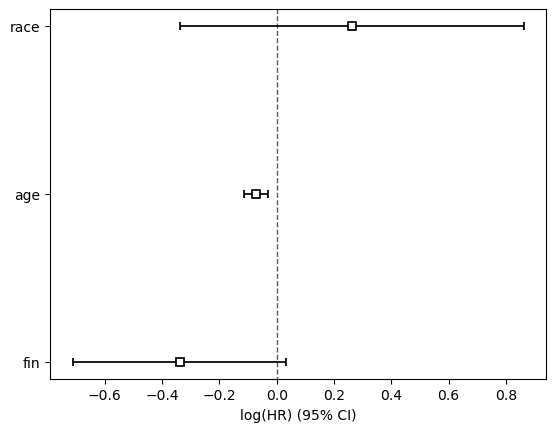

In [14]:
cph = CoxPHFitter()
cph.fit(step1, duration_col='time', event_col='event')
cph.plot()

<Axes: >

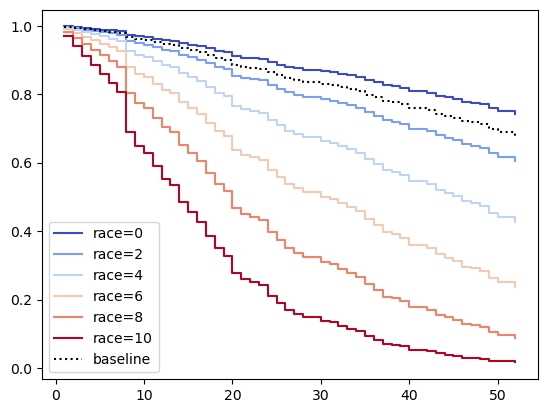

In [15]:
cph.plot_partial_effects_on_outcome(covariates='race', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [16]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -665.84
         time fit was run = 2024-02-18 09:18:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.34       0.71       0.19            -0.71             0.03                 0.49                 1.03
age        -0.07       0.93       0.02            -0.11            -0.03                 0.89                 0.97
race        0.26       1.30       0.31            -0.34             0.86                 0.71                 2.37

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.78   0.07       3.75
age           0.00 -3.42 <0.005      10.63
race          0.00  0.86   0.39       1.36
---
Concordance = 0.61
Partial AIC = 1337.68
log-likelihood ratio test = 19.08 on 3 df
-log2(p) of ll-ratio test = 11.89

In [17]:
coef = cph.params_

In [18]:
pd.DataFrame(coef)

,coef
covariate,
fin,-0.339217
age,-0.071613
race,0.262437


In [19]:
# coef must be a column vector
coef_df = pd.DataFrame(coef)

# Ensure the columns match between df and coef_transposed
coef_df = coef_df.reindex(X1.columns)

# Calculate the linear scores
linear_scores = X1.mul(coef_df.iloc[:, 0], axis=1).sum(axis=1)


In [20]:
linear_scores_df = pd.DataFrame(linear_scores, columns=["score"])

In [21]:
linear_scores_df[:5]

,score
0,-1.671111
1,-1.026595
2,-1.360645
3,-1.723876
4,-1.360645


In [22]:
step2["offset"] = linear_scores
step2

,offset,time,event,wexp,mar,paro,prio
0,-1.671111,20,1,0,0,1,3
1,-1.026595,17,1,0,0,1,8
2,-1.360645,25,1,1,0,1,13
3,-1.723876,52,0,1,1,1,1
4,-1.360645,52,0,1,0,1,3
...,...,...,...,...,...,...,...
427,-2.559217,52,0,1,0,1,3
428,-1.169820,52,0,0,0,1,1
429,-1.509038,52,0,1,1,1,1
430,-1.814336,52,0,1,0,1,3


In [23]:
step2.to_csv("step2.csv")

In [24]:
## building initial points, to help converge offset to 1 faster, but it doesn't impact too much the time
ip = np.zeros(step2.shape[1]-2) ## 2 are time and event columns
ip[0]=1 
ip.shape

(5,)

<Axes: xlabel='log(HR) (95% CI)'>

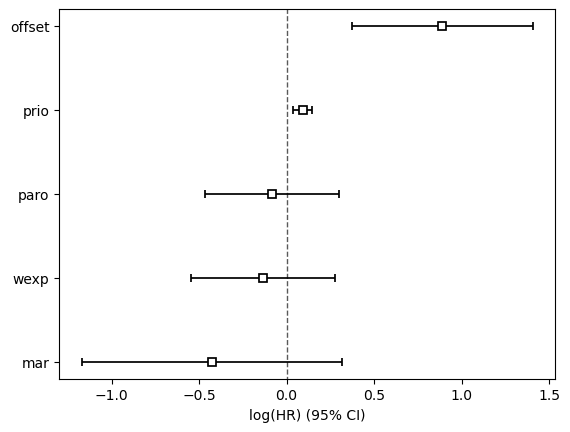

In [25]:
cph = CoxPHFitter()
cph.fit(step2, duration_col='time', event_col='event', initial_point=ip)
cph.plot()

In [26]:
data = pd.read_csv("DaniDatasets/preprocessed.csv", index_col=0)
omic_indices = pd.read_csv("DaniDatasets/indices_for_preprocessed.csv")

In [27]:
data.iloc[:,:4]

,AGE,GENDER,event,time
TCGA-2F-A9KO,63.0,0.0,1.0,24.131242
TCGA-2F-A9KQ,69.0,0.0,0.0,94.881152
TCGA-2F-A9KR,59.0,1.0,1.0,104.645428
TCGA-2F-A9KT,83.0,0.0,0.0,108.952231
TCGA-4Z-AA7M,65.0,0.0,0.0,16.273794
...,...,...,...,...
TCGA-ZF-AA53,60.0,0.0,0.0,57.895256
TCGA-ZF-AA54,71.0,0.0,1.0,19.397048
TCGA-ZF-AA56,79.0,1.0,1.0,8.514975
TCGA-ZF-AA58,61.0,1.0,0.0,54.213105


In [28]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=1)
cph.fit(data, duration_col='time', event_col='event', show_progress=True)
#cph.plot()

Iteration 1: norm_delta = 3.29e+00, step_size = 0.9500, log_lik = -285656.54054, newton_decrement = 6.26e+02, seconds_since_start = 124.1
Iteration 2: norm_delta = 2.90e+00, step_size = 0.9500, log_lik = -219644.40168, newton_decrement = 1.64e+02, seconds_since_start = 240.8
Iteration 3: norm_delta = 5.90e+00, step_size = 0.9500, log_lik = -169051.80874, newton_decrement = 7.26e+02, seconds_since_start = 357.6
Iteration 4: norm_delta = 1.26e+01, step_size = 0.2327, log_lik = -130199.39690, newton_decrement = 3.92e+03, seconds_since_start = 478.9
Iteration 5: norm_delta = 3.32e+00, step_size = 0.0741, log_lik = -100241.94350, newton_decrement = 3.87e+02, seconds_since_start = 598.5
Iteration 6: norm_delta = 2.16e+00, step_size = 0.0944, log_lik = -77193.81549, newton_decrement = 2.05e+02, seconds_since_start = 717.3
Iteration 7: norm_delta = 1.42e+00, step_size = 0.1596, log_lik = -59465.92257, newton_decrement = 1.14e+02, seconds_since_start = 836.3
Iteration 8: norm_delta = 1.29e+00, 

/home/ronin/miniforge3/envs/ai/lib/python3.12/site-packages/lifelines/utils/__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/home/ronin/miniforge3/envs/ai/lib/python3.12/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column alterations_ACVR1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'alterations_ACVR1'].var())
>>> print(df.loc[~events, 'alterations_ACVR1'].var())

A very low variance means that the column alterations_ACVR1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(deden

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [ ]:
pandas2ri.activate()

# Convert the DataFrame to an R dataframe
r_df = pandas2ri.py2rpy( pd.concat([data, pd.DataFrame([0] * data.shape[0], columns=["offset"])], axis=1) )
#r_df = pandas2ri.py2rpy( step2 )

# todo building R script, note eime event offset are hardcoded, use them as hyperparam
r_script = '''
library(survival)
library(glmnet)

# Define the function
cox_lasso_model_with_offset <- function(df) {
  # Check for necessary columns
  required_cols <- c("time", "event", "offset")
  if (!all(required_cols %in% names(df))) {
    stop("Dataframe missing required columns: time, event, or offset")
  }
  
  # Prepare the survival object
  y <- with(df, Surv(time, event))
  
  # Prepare the matrix of predictors
  predictors <- setdiff(names(df), required_cols)
  x <- as.matrix(df[, predictors])
  
  # Extract the offset
  offset_values <- df$offset
  
  # Fit Cox model with Lasso using cross-validation
  fit <- cv.glmnet(x, y, family="cox", alpha=1, offset=offset_values) 
  
  # Best lambda and model fit
  best_lambda <- fit$lambda.min
  best_fit <- glmnet(x, y, family="cox", alpha=1, lambda=best_lambda, offset=offset_values)
  
  # Extracting coefficients
  coef_vector <- as.vector(coef(best_fit, s = best_lambda))
  
  # handling intercept is not strictly recommended in COX, and not itnterpretable, 
  # so I'm leaving it out
  # coef_df <- data.frame(coefficient = coef_vector, row.names = c("(Intercept)", predictors))
  coef_df <- data.frame(coefficient = coef_vector, row.names = predictors)
  
  # Return results
  return(list(coef=coef_df, lambda=best_lambda, fit=best_fit))
}
'''

# Run the R script and access the R function
robjects.r(r_script)
cox_lasso_model_with_offset = robjects.globalenv['cox_lasso_model_with_offset']

# Call the function with the R dataframe
result = cox_lasso_model_with_offset(r_df)

# Printing the result
print(result[0])

In [ ]:
# Convert the R dataframe to a pandas DataFrame
coefficient_df = pandas2ri.rpy2py(result[0])

In [ ]:
step2[:2]

In [ ]:
coefficient_df

In [ ]:
offset_row = pd.DataFrame({'coefficient': [1]})
offset_row.index = ['offset']

In [ ]:
X2[:2]

In [ ]:
coefficients_with_offset = pd.concat([offset_row, coefficient_df])

In [ ]:
coefficients_with_offset

In [ ]:
offset_row

In [ ]:
# Calculate the linear scores
linear_scores_2 = X2.mul(coefficient_df.iloc[:, 0], axis=1).sum(axis=1)

In [ ]:
pd.DataFrame({"linear_score_1":linear_scores,
            "linear_score_2":linear_scores_2})